In [1]:
# Change to project root
import os
os.chdir('..')

In [2]:
# Autoreload
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf
import numpy as np

In [14]:
parallel_calls = 8
max_trans = 3
stddev = 0.1

# Load the data

In [15]:
from transforming_autoencoders import mnist, data
mnist_data = mnist.MNIST('data')

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [16]:
def train_input_fn(batch_size):
    return mnist_data.train_input_fn()(batch_size,
                                       lambda: data.affine_fn(batch_size, stddev, max_trans),
                                       parallel_calls)
def eval_input_fn(batch_size):
    return mnist_data.eval_input_fn()(batch_size,
                                      lambda: data.affine_fn(batch_size, stddev, max_trans),
                                      parallel_calls)

# Create the estimator

In [20]:
from transforming_autoencoders import trans_autoencoder_estimator
model = trans_autoencoder_estimator.create_transforming_autoencoder(model_dir='model/affine',
                                                                    num_capsules=30,
                                                                    num_rec=50,
                                                                    num_gen=50,
                                                                    trans_size=8,
                                                                    trans_fn='affine')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'model/affine', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f23957d5f98>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


# Train the model

In [21]:
batch_size = 64
epochs = 6
steps = int(mnist_data.train_size() * epochs / batch_size)
model.train(input_fn=lambda:train_input_fn(batch_size), steps=steps)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into model/affine/model.ckpt.
INFO:tensorflow:loss = 0.37844738, step = 1
INFO:tensorflow:global_step/sec: 25.6182
INFO:tensorflow:loss = 0.08292472, step = 101 (3.904 sec)
INFO:tensorflow:global_step/sec: 50.1656
INFO:tensorflow:loss = 0.079643875, step = 201 (1.993 sec)
INFO:tensorflow:global_step/sec: 48.0244
INFO:tensorflow:loss = 0.06925725, step = 301 (2.083 sec)
INFO:tensorflow:global_step/sec: 45.4588
INFO:tensorflow:loss = 0.067290306, step = 401 (2.199 sec)
INFO:tensorflow:global_step/sec: 43.0852
INFO:tensorflow:loss = 0.06621786, step = 501 (2.323 sec)
INFO:tensorflow:global_step/sec: 44.6603
INFO:tensorflow:loss = 0.07064296, step = 601 (2.237 sec)
INFO:tensorflow:global_step/sec: 49.1319
INFO:tensor

# Evaluate the model

In [22]:
test_data = eval_input_fn(4)
with tf.Session() as sess:
    img, trans, expec = sess.run([test_data[0]['image'],
                                 test_data[0]['transformation'],
                                 test_data[1]])

In [23]:
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"image": img, "transformation": trans},
    num_epochs=1,
    shuffle=False)
yhat = list(model.predict(input_fn=predict_input_fn))
pred = np.array(list(map(lambda x: x['out_image'], yhat)))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from model/affine/model.ckpt-5156
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


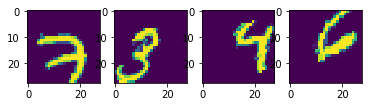

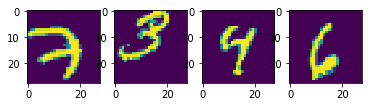

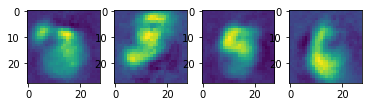

[[ 0.92340314 -0.08825365  4.657329    0.00611555  0.9811933   2.372975
   0.          0.        ]
 [ 0.7713575  -0.04668379  1.8864113   0.15945038  1.2234573   3.6833088
   0.          0.        ]
 [ 1.1779684   0.17133403  2.267608    0.01605221  1.0185778  -1.1051764
   0.          0.        ]
 [ 1.3881019  -0.15428981  2.1287398  -0.2551152   0.95205826 -2.4686186
   0.          0.        ]]


In [24]:
from transforming_autoencoders import plot
plot.plot_some(img)
plot.plot_some(expec)
plot.plot_some(pred)
print(trans)